In [1]:
import cooltools
import cooler
from cooltools.eigdecomp import cis_eig
import numpy as np
import matplotlib.pyplot as plt

In [2]:
clr = cooler.Cooler('K562_hg19_chr3_50K.cool')
mat = clr.matrix(balance=True)[:]

The FPKM file contains gene expression levels
the H3K27me3 bigwig file contains ChIP-seq normalized signal
the GC file contains GC content data at 50Kb resolution.

In [3]:
phasing = [] #phasing track is correcting for GC content

for line in open('hg19_GC_chr3_50K.txt'):
    line = line.rstrip()
    phasing.append(line)
    phasing_array = np.array(phasing)
    float_phasing_array = phasing_array.astype(float)
print(float_phasing_array)
print(type(float_phasing_array))

[0.      0.16752 0.23058 ... 0.22148 0.06538 0.     ]
<class 'numpy.ndarray'>


To capture the pattern of compartmentalization within-chromosomes, in cis, cooltools cis_eig first removes the dependence of contact frequency by distance, and then performs eigenedecompostion

Basically finding eigen vectors and values of this matrix

In [4]:
cis_eigs = cooltools.eigdecomp.cis_eig(mat, n_eigs=1, phasing_track=float_phasing_array)
cis_eigs

(array([5531.58103207]),
 array([[        nan, -0.07931084,  0.08391484, ...,         nan,
                 nan,         nan]]))

#### Plot the first eigen vector, along with the interaction matrix such that you can see the relationship between eigen vector scores and compartment patterns in the Hi-C data (compartment scores over heatmap). You may need to play with the vmax argument in the matplotlib matshow function to get a good dynamic range of the data (this puts a cap on the maximum score displayed). I used ten times the median score of all of the nonzero interactions, but you can play around with this number if you like.

Hint: You can look at the examples in the documentation for ways to nicely combine the two plots.
Create a bed file from the first eigen vector with each ‘A’ and ‘B’ region as determined by the sign of the eigen vector score.

vmax = resolution; any score higher than x numbr will be cut off and predent it's lower than it actually is 

/opt/anaconda3/envs/hic/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


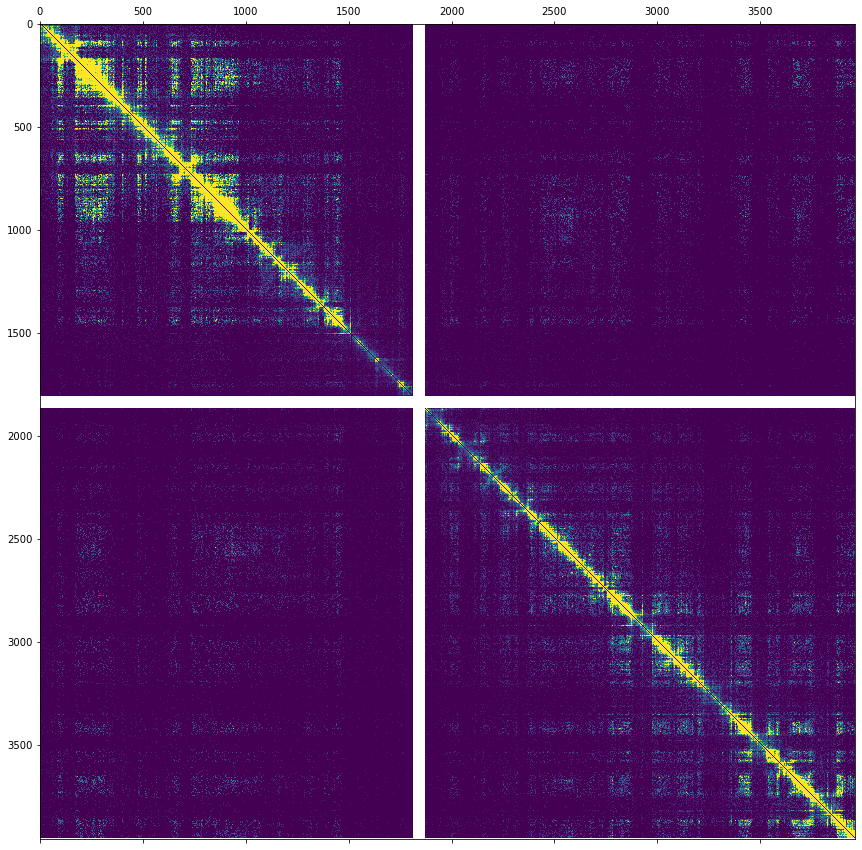

In [5]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(mat, vmax=10) 
fig.show()


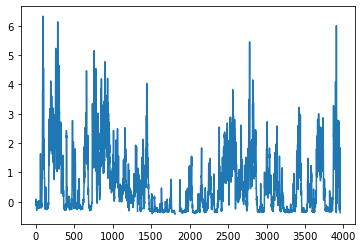

In [6]:
plt.plot(np.arange(cis_eigs[1].shape[1]), cis_eigs[1][0,:])
plt.show()


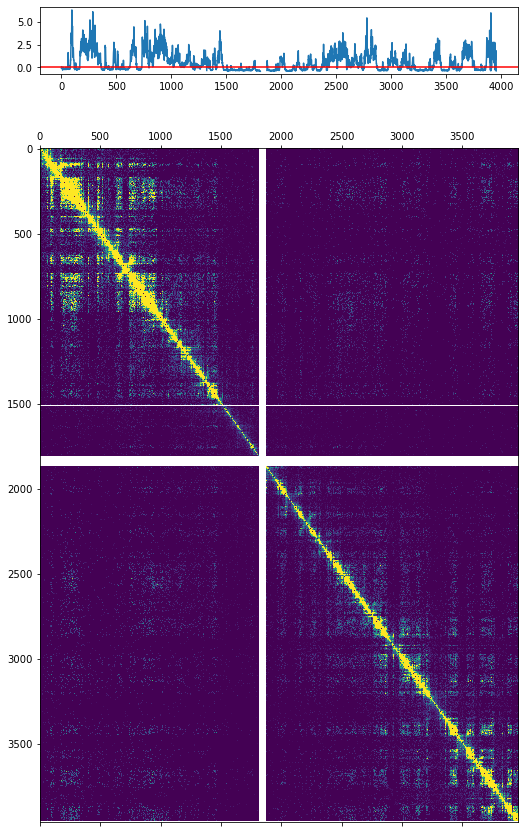

In [7]:
import matplotlib.gridspec as grd

plt.figure(figsize = (15, 15))

gs = grd.GridSpec(2, 2, height_ratios=[1,10], width_ratios=[6,1], wspace=1)
ax = plt.subplot(gs[2])
ax = ax.matshow(mat, aspect="auto", vmax=10)
ax2 = plt.subplot(gs[0])
ax2.plot(np.arange(cis_eigs[1].shape[1]), cis_eigs[1][0,:])
plt.axhline(y=0, color='r')
plt.show()

#### Create a bed file from the first eigen vector with each ‘A’ and ‘B’ region as determined by the sign of the eigen vector score.

In [8]:
vector = cis_eigs[1][0] #just take vector, not value
vector.size #number of vals in array; each entry in eigenvector corresponds to a 50kb region in GC.txt file

3961

In [9]:
vector

array([        nan, -0.07931084,  0.08391484, ...,         nan,
               nan,         nan])

In [10]:
for i in range(30): #each value = 50kb of sequences
    print(vector[i])

nan
-0.07931083826290435
0.08391483795285734
0.020301722842777033
-0.004100291122681861
-0.01798649968357054
-0.1363552482575583
-0.05943947353149831
-0.020357441132418802
0.0019385587536206207
-0.06425311600208206
-0.25979067733140926
-0.2979900713737611
-0.15782970193376675
-0.1157767935944717
-0.16733585283700458
-0.04005228198402534
-0.11484701248461603
-0.13116337496396763
0.009646915820457496
-0.14133459695987116
-0.19933209207888564
-0.18218469252425795
-0.14598115603130485
-0.11027670231837491
-0.08549842212573035
-0.15079332592571296
-0.22372000542014384
-0.1444153916547013
-0.14335134882189066


In bedfile:
0       - 500,000 A(+)
500,000 - 550,000 B(-)

In [11]:
positions = np.arange(0, 198050000, 50000) 
positions

array([        0,     50000,    100000, ..., 197900000, 197950000,
       198000000])

In [27]:
AB = []
filtered_pos = []
for i in range(len(vector)):
    if np.isnan(vector[i]):
        continue
    elif vector[i] > 0:
        AB.append("A")
        filtered_pos.append(positions[i])
    elif vector[i] < 0:
        AB.append("B")
        filtered_pos.append(positions[i])

In [28]:
sign_switch = []
for i in range(1, len(AB)):
    if AB[i] == AB[i-1]:
        continue
    else:
        sign_switch.append(i)  

In [29]:
start_list = [filtered_pos[0]]
for i in range(1, len(sign_switch)):
    start_list.append(filtered_pos[sign_switch[i-1]])

In [15]:
print(start_list[0])
print(filtered_pos[1])

50000
100000


In [17]:
f = open("bedfile.bed", "w")
for i in range(len(sign_switch)):
    f.write('\t'.join(["chr3", str(start_list[i]), str(filtered_pos[sign_switch[i]]), str(AB[sign_switch[i]-1])+'\n']))

f.close()
        


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
col_names= ["chr", "start", "end", "gene", "FPKM", "strand"]
df = pd.read_csv('K562_hg19_FPKM_chr3.bed', names=col_names, sep="\t", header=None)
df

chr      start        end    gene     FPKM strand
0     chr3     238279     451090    CHL1     0.00      +
1     chr3    1134260    1445901   CNTN6     0.00      +
2     chr3    2140497    3099645   CNTN4     0.01      +
3     chr3    3111233    3168297   IL5RA     0.14      -
4     chr3    3168600    3192563   TRNT1    25.28      +
...    ...        ...        ...     ...      ...    ...
1059  chr3  197464050  197514467  FYTTD1    53.14      +
1060  chr3  197518097  197615307   LRCH3    24.13      +
1061  chr3  197615946  197687013    IQCG     3.70      -
1062  chr3  197676858  197683481  RPL35A  1195.67      +
1063  chr3  197687071  197770591    LMLN     5.71      +

[1064 rows x 6 columns]

In [20]:
df["FPKM"] = np.log2(df["FPKM"]+1)
df

chr      start        end    gene       FPKM strand
0     chr3     238279     451090    CHL1   0.000000      +
1     chr3    1134260    1445901   CNTN6   0.000000      +
2     chr3    2140497    3099645   CNTN4   0.014355      +
3     chr3    3111233    3168297   IL5RA   0.189034      -
4     chr3    3168600    3192563   TRNT1   4.715893      +
...    ...        ...        ...     ...        ...    ...
1059  chr3  197464050  197514467  FYTTD1   5.758623      +
1060  chr3  197518097  197615307   LRCH3   4.651339      +
1061  chr3  197615946  197687013    IQCG   2.232661      -
1062  chr3  197676858  197683481  RPL35A  10.224810      +
1063  chr3  197687071  197770591    LMLN   2.746313      +

[1064 rows x 6 columns]

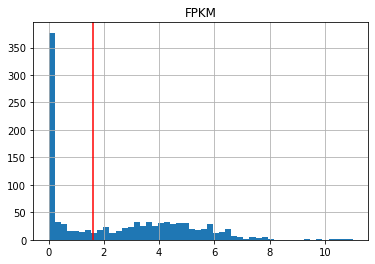

In [21]:
hist = df.hist(column=["FPKM"], bins=50)
plt.axvline(x=1.6, ymax=1, color='r')

1) Adjust H3kme7 scores
2) Map H3 scores onto genes using bedtools map
3) Normalize gene length
4) Map onto compartments

$bedtools map -a K562_hg19_FPKM_chr3.bed -b K562_hg19_H3K27me3_chr3_norm.bg > me3_gene_map.bed

$awk 'BEGIN{OFS="\t"}{$7=$7 / ($3-$2); print $1,$2,$3,$4,$5,$6,$7}' me3_gene_map.bed > K562_hg19_FPKM_chr3_mapnorm.bed

$bedtools map -a K562_hg19_FPKM_chr3_mapnorm.bed -b bedfile.bed -o distinct -f 0.5 -c 4 > ABmapped.bed

-c default 5 parameters, switch to 4
-f Minimum overlap required as a fraction of A. Default is 1E-9 (i.e. 1bp).

FPKM = gene expression; over red line threshold

Need to subset out data for A-expressed (FPKM > 1.6), B-expressed, etc.)

In [22]:
col_names2 = ["chr", "start", "end", "gene", "FPKM", "strand", "methylation", "compartment"]
ABmapped = pd.read_csv('ABmapped.bed', sep='\t', names = col_names2, header=None)
ABmapped

chr      start        end    gene     FPKM strand  methylation  \
0     chr3     238279     451090    CHL1     0.00      +     0.217979   
1     chr3    1134260    1445901   CNTN6     0.00      +     0.212417   
2     chr3    2140497    3099645   CNTN4     0.01      +     0.271694   
3     chr3    3111233    3168297   IL5RA     0.14      -     1.567160   
4     chr3    3168600    3192563   TRNT1    25.28      +     0.168837   
...    ...        ...        ...     ...      ...    ...          ...   
1059  chr3  197464050  197514467  FYTTD1    53.14      +     0.170634   
1060  chr3  197518097  197615307   LRCH3    24.13      +     0.174287   
1061  chr3  197615946  197687013    IQCG     3.70      -     0.264840   
1062  chr3  197676858  197683481  RPL35A  1195.67      +     0.173857   
1063  chr3  197687071  197770591    LMLN     5.71      +     0.141797   

     compartment  
0              B  
1              B  
2              B  
3              A  
4              A  
...          ...  
1059           A  
1060           A  
1061           A  
1062           A  
1063           A  

[1064 rows x 8 columns]

In [23]:
A_expressed = ABmapped.loc[(ABmapped["FPKM"] > 1.6) & (ABmapped["compartment"] == "A")]
B_expressed = ABmapped.loc[(ABmapped["FPKM"] > 1.6) & (ABmapped["compartment"] == "B")]

In [24]:
A_unexpressed = ABmapped.loc[(ABmapped["FPKM"] < 1.6) & (ABmapped["compartment"] == "A")]
B_unexpressed = ABmapped.loc[(ABmapped["FPKM"] < 1.6) & (ABmapped["compartment"] == "B")]

In [25]:
print(A_expressed["methylation"])

4       0.168837
5       0.140221
6       0.391641
8       0.180047
9       0.387860
          ...   
1059    0.170634
1060    0.174287
1061    0.264840
1062    0.173857
1063    0.141797
Name: methylation, Length: 561, dtype: float64


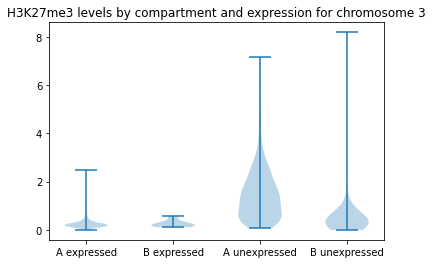

In [26]:
fig, ax = plt.subplots()

ax.violinplot([A_expressed["methylation"], B_expressed["methylation"], A_unexpressed["methylation"], B_unexpressed["methylation"]])

plt.xticks(ticks=[1, 2, 3, 4], labels = ["A expressed", "B expressed", "A unexpressed", "B unexpressed"])

ax.set_title('H3K27me3 levels by compartment and expression for chromosome 3')

plt.show()